In [1]:

import os
import keras
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#from google.colab import drive


In [2]:
#drive.mount('/content/drive')

In [3]:
train_path = "guitarchordsv3_archive/Training" # assuming this notebook is in the same directory as guitarchordsv3_archive
test_path = "guitarchordsv3_archive/Test"

sr = 16000  # sampling rate
n_mfcc = 80  # No. of mfcc features
N_CLASSES = 8  # No. of classes

In [4]:
def extract_mfcc(file, sr):
    audio, sr = librosa.load(file, sr=sr)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [5]:
def extract_spectrogram(file, sr, minlength):
    audio, sr = librosa.load(file, sr=sr)
    # Compute the spectrogram. n_mels is frequency step size, fmax is maximum frequency
    n_mels=128
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
    # Convert the spectrogram to decibel scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    #could use np.abs on the spectrogram
    
    # Need to pad or chop wav files. Only take first minlength of values, or pad with zeros until minlength is reached.
    spectrogram_db = spectrogram_db[:,:minlength] # python index slicing all rows with only minlength of columns
    d1, d2 = spectrogram_db.shape #extract the length of columns
    padding = np.zeros((n_mels, np.abs(minlength - d2))) # Create a 2D NumPy zeros array with rows=n_mels, for concat to work
    spectrogram_db_padded = np.concatenate((padding,spectrogram_db), axis=1) # concat columns axis only. Front padding first.
    # CNN expects single channel dimension (gray scale)
    spectrogram_db_dim = np.expand_dims(spectrogram_db_padded,axis=2)
    return spectrogram_db_dim

In [13]:
def get_data(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes
    le = LabelEncoder()
    le.fit(classes)

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)

    N = len(wav_paths)
    X = np.empty((N, n_mfcc), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_mfcc(wav_file, sr)
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES)
    print(classes)
    print(labels)

    return X, Y

In [14]:
def get_data_spectrograms(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes/chords
    le = LabelEncoder()
    le.fit(classes) # give label encoder the list of chords to classify

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)  # remaps chord names to integer values
    # labels array now has integer value (chord label) for each corresponding 1440 wav files
    
    # Need to pad or chop wav files. Only take first 48000 samples, or about first 3 seconds of wav audio
    N = len(wav_paths)  # length of wav_paths and labels should be exactly the same
    minHeight = 128 # height of input, also same as n_mels, which is frequency step size
    minLength = 200 # length of input
    X = np.empty((N, minHeight, minLength, 1), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_spectrogram(wav_file, sr, minLength) #samplerate=16000
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES) # one hot encoding. Converts a list of integers to binary flag with num_classes length.
    print(classes)
    print(labels)
    

    return X, Y

In [16]:
def model_dense():
    model = Sequential()

    model.add(Dense(128, input_shape=(80,), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [17]:
X, Y = get_data(train_path)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 80)
Shape of Y: (1440, 8)


In [18]:
model = model_dense()
model.summary()

C:\Users\Derrick\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,528 (99.72 KB)

 Trainable params: 25,528 (99.72 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def model_conv2d():
    model = Sequential()

    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(128, 200, 1)))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

In [20]:
model2 = model_conv2d()
model2.summary()

C:\Users\Derrick\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 198, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 196, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 388864)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │      24,887,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,890,360 (94.95 MB)

 Trainable params: 24,890,360 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
batch_size = 16
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1345 - loss: 16.3809
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1144 - loss: 7.6620
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1236 - loss: 4.7044 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1066 - loss: 4.1992
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1471 - loss: 3.0617
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1444 - loss: 3.0197
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1132 - loss: 2.5161 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1273 - loss: 2.5345 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1259 - loss: 2.4944
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1228 - loss: 2.3946


In [21]:
x_train, y_train = get_data_spectrograms(train_path)
print(f"Shape of X: {x_train.shape}")
print(f"Shape of Y: {y_train.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 128, 200, 1)
Shape of Y: (1440, 8)


In [22]:
epochs = 3
batch_size = 16
history = model2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4437 - loss: 238.9346
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9806 - loss: 0.3105
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.9820 - loss: 0.1704


In [23]:
history_dict = history.history
loss_list = history_dict['loss']
accuracy_list = history_dict['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list)*100, decimals=2)}%")

Minimum Loss = 0.1
Maximum Accuracy = 98.26%


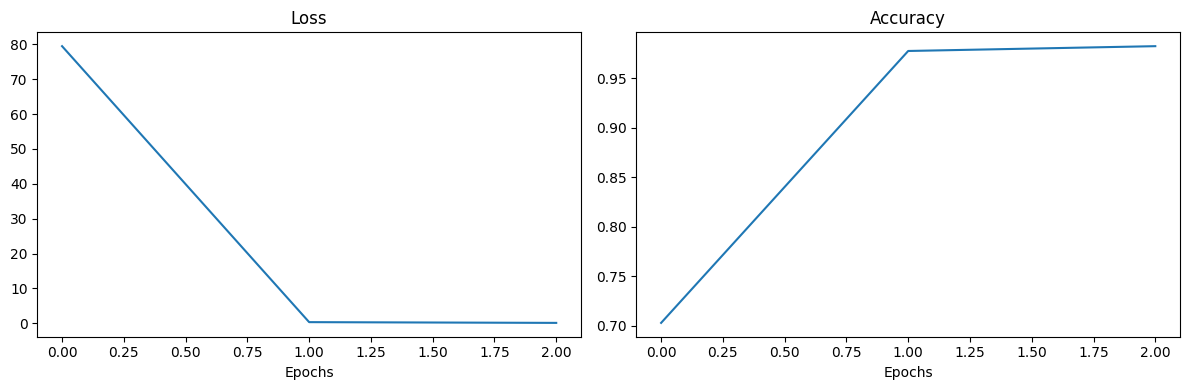

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), loss_list)
plt.title("Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), accuracy_list)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [21]:

# Save the trained model
model2.save('models/cnn2.h5')  # Change the path if needed